In [1]:
%load_ext Cython
from scipy import sparse
from scipy.spatial import distance
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import euclidean_distances
from math import sqrt
import matplotlib.pyplot as plt
import random
import gudhi

In [2]:
%%cython
cimport numpy
import numpy as np

DTYPE = np.intc

cdef class neuron:
    
    cdef public int name, state, memory, rest
    cdef public float threshold
    cdef public list history
    
    def __init__(self, int name, int state = False, int memory = 0, int rest = 0, float threshold = 0.1):
        self.name = name
        self.state = state
        self.memory = memory
        self.rest = rest
        self.threshold = threshold
        
        self.refresh_history()
        
    def refresh_history(self):
        self.history = []

In [3]:
%%cython
cimport numpy
cimport cython
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from math import sqrt
import gudhi

DTYPE = np.int64

ctypedef fused A:
    int
    long
ctypedef fused link_list:
    int
    long
ctypedef fused stubs:
    int
    long

ctypedef numpy.int_t DTYPE_t


cdef class Geometric_Brain_Network:
    
    cdef int N, GD, nGD
    cdef str manifold, text
    cdef public list nodes
    cdef public numpy.ndarray A
    cdef public int time
    
    def __init__(self, int size, int geometric_degree = 1, int nongeometric_degree = 0, str manifold = 'Ring'):
        
        self.N = size  
        self.GD = geometric_degree
        self.nGD = nongeometric_degree
        self.manifold = manifold
        self.text = '%s Network on %d nodes'%(self.manifold, self.N)
        A = np.zeros((self.N,self.N), dtype = np.int64)
        
        self.make_geometric(A)
        
        if self.nGD > 0: self.add_noise_to_geometric()
        
    def get_neurons(self, list neurons):

        if len(neurons) != self.N: 
            raise ValueError('Size of the network and the number of neurons should match')
        
        self.nodes = neurons
    
    def make_geometric(self, numpy.ndarray[DTYPE_t, ndim=2] A):
        
        cdef int gd, v
        cdef Py_ssize_t u, i
        
        self.A = A
        
        if self.manifold == 'Ring':
            
            #if self.GD >= int(self.N)-1: 
                #raise InputError('Geometric Degree cannot exceed the half of the size of the network.')
            #elif self.GD<1 or self.GD%2 == 1:
                #raise InputError('Geometric Degree should be an even positive integer.')
            
            gd = int(self.GD/2)
            for u in range(self.N):
                for i in range(1, gd + 1):
                    #from left
                    if u + i >= self.N: 
                        v = u + i - self.N
                    else: v = u + i
                    self.A[u,v] = True
                    #from right
                    if u - i < 0: 
                        v = self.N + u - i
                    else: v = u - i
                    self.A[u,v] = True
            self.text = self.text + ' w/ GD %d'%(self.GD)
    
    def add_noise_to_geometric(self):#, numpy.ndarray[DTYPE_t, ndim=2] A):

        cdef Py_ssize_t i, m, n, k
        cdef int M, flag_2, flag_1, node_A, node_B, count, rand1, rand2
        cdef numpy.ndarray nongeo, index
        cdef numpy.ndarray link_list
        cdef numpy.ndarray stubs 
        
        M = int(self.N * self.nGD)
        
        #if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
        flag_2 = True
            
        while flag_2:
            flag_2 = False
            #build stubs
            stubs = np.zeros((M), dtype = DTYPE)
            nongeo = np.ones((self.nGD), dtype = np.int64)
            for i in range(self.N):
                index = (i*self.nGD) + np.arange(self.nGD, dtype = np.int64)
                stubs[index[0]:index[-1]+1] = (i) * np.asarray(nongeo)
                    
            #build undirected link list
            link_list = np.zeros((int(M/2),2), dtype = DTYPE)
            for m in range(int(M/2)):
                flag_1 = True # turn on flag to enter while loop
                count = 0
                while flag_1:
                    flag_1 = False #turn off flag to exit while loop
                    rand1 = random.randint(0, len(stubs)-1)
                    rand2 = random.randint(0, len(stubs)-1)
                    
                    node_A = int(stubs[rand1])
                    node_B = int(stubs[rand2])
                                            
                    if node_A == node_B: flag_1 = True
                    
                    for n in range(m):
                        if link_list[n,0] == node_A and link_list[n,1] == node_B:
                            flag_1 = True
                        if link_list[n,0] == node_B and link_list[n,1] == node_A:
                            flag_1 = True
                        if self.A[node_A][node_B] == 1 or self.A[node_B][node_A] == 1:
                            flag_1 = True
                            
                    count = count +1
                    
                    if count > M: flag_2 = True ; break
                        
                #make link       
                link_list[m,0] = node_A
                link_list[m,1] = node_B
                
                #remove stubs from list
                stubs = np.delete(stubs,[rand1,rand2])
        
        #build network
        for k in range(int(M/2)):
            self.A[link_list[k,0],link_list[k,1]] = True
            self.A[link_list[k,1],link_list[k,0]] = True
        self.text = self.text + ' and nGD %d'%self.nGD
    
    def neighbors(self, int node_id):
        
        cdef numpy.ndarray nhood
        
        nhood = np.nonzero(self.A[node_id])[0]

        return(nhood)
    
    def neighbor_input(self, int node_id):
        cdef numpy.ndarray nbhood
        cdef Py_ssize_t i
        cdef int e
        cdef list active_hood
        cdef float F

        nbhood = self.neighbors(node_id)
        active_hood = []
        
        for i,e in enumerate(nbhood):
            if self.nodes[e].state == 1:
                active_hood.append(e)
                
        F = len(active_hood)/len(nbhood) - self.nodes[node_id].threshold
        
        return(F)
    
    def sigmoid(self, int node_id, int C):
        
        cdef float F, Z

        F = self.neighbor_input(node_id)
        Z = 1/(1+np.exp(-C*F))
        
        return(Z)
    
    def update_history(self, int node_id, int C):
        cdef float rand
        cdef Py_ssize_t i,j
        
        rand = random.uniform(0,1)
        
        if rand <= self.sigmoid(node_id, C):
            
            for i in range(self.nodes[node_id].memory + 1):
                self.nodes[node_id].history.append(1)
                
            for j in range(self.nodes[node_id].rest):
                self.nodes[node_id].history.append(-1)
                
            self.nodes[node_id].history.append(0)
            
        else:
            self.nodes[node_id].history.append(0)
    
    def update_states(self):
        cdef list excited, ready_to_fire, rest
        
        cdef object node
        
        excited = []
        ready_to_fire = []
        rest = []
        
        for node in self.nodes:
            
            node.state = int(node.history[self.time])
                
            if node.state == 1:
                excited.append(node.name)
            elif node.state == 0:
                ready_to_fire.append(node.name)
            else: rest.append(node.name)
                
        return(excited, ready_to_fire, rest)
                
    def initial_spread(self, int seed):
        cdef Py_ssize_t i, j, k
        cdef set excited_nodes_set, all_nodes
        cdef int node1, node2
        cdef list excited_nodes_list

        all_nodes = set([k for k in range(self.N)])
        excited_nodes_list = list(self.neighbors(seed))
        excited_nodes_set = set(excited_nodes_list)
        
        for node1 in excited_nodes_list:
            for i in range(self.nodes[node1].memory + 1):
                self.nodes[node1].history.append(1)
            for j in range(self.nodes[node1].rest):
                self.nodes[node1].history.append(-1)
                
            self.nodes[node1].history.append(0)
            
        for node2 in list(all_nodes.difference(excited_nodes_set)):
            self.nodes[node2].history.append(0)
            
    def refresh(self):
        cdef int tolerance
        cdef object node
        
        self.time = 0
        tolerance = 0
        
        for node in self.nodes:
            node.refresh_history()
            
        return(tolerance)
    
    def run_dynamic(self, int seed, int TIME, int C):
        
        cdef numpy.ndarray activation_times
        cdef list size_of_contagion, excited_nodes, ready_to_fire_nodes, resting_nodes
        cdef int node, tolerance, flag_1
        cdef Py_ssize_t i

        tolerance = self.refresh()
        activation_times = np.ones(self.N, dtype = np.int64)*TIME
        size_of_contagion = [int(0)]
        self.initial_spread(seed)
        excited_nodes, ready_to_fire_nodes, resting_nodes = self.update_states()
        
        self.time = 1
        
        while self.time < TIME and 0 < len(excited_nodes) and np.any(activation_times==TIME) and tolerance < 20:
            size_of_contagion.append(len(excited_nodes))
            
            activation_times[excited_nodes] = np.minimum(activation_times[excited_nodes], 
                                                         np.array([self.time]*len(excited_nodes)))
            
            
            for node in ready_to_fire_nodes: 
                self.update_history(node, C)
            
            flag_1 = len(excited_nodes)
            excited_nodes, ready_to_fire_nodes, resting_nodes = self.update_states()
            
            if flag_1 == len(excited_nodes):
                tolerance = tolerance + 1
            
            self.time = self.time + 1
        
        if len(size_of_contagion) < TIME:
            for i in range(len(size_of_contagion), TIME):
                size_of_contagion.append(size_of_contagion[-1])

        return(activation_times, np.array(size_of_contagion))
    
    def stack_histories(self, int TIME):
        cdef object node
        cdef list states
        cdef numpy.ndarray all_history
        cdef Py_ssize_t i
        
        for node in self.nodes:
            if len(node.history) < TIME:
                node.history = node.history + [node.history[-1] for i in range(len(node.history), TIME)]
            node.history = node.history[:TIME]
        states = [node.history for node in self.nodes]
        all_history = np.vstack(states)
        return(all_history)
    
    def average_over_trials(self, int seed, int TIME, int C, int trials):
        
        cdef numpy.ndarray first_excitation_times, size_of_contagion, first_exct, contagion_size
        cdef numpy.ndarray average_excitation_times, average_contagion_size
        cdef Py_ssize_t i

        first_excitation_times = np.zeros((self.N, trials), dtype = np.int64)
        size_of_contagion = np.zeros((TIME, trials), dtype = np.int64)
        
        for i in range(trials):
            first_exct, contagion_size = self.run_dynamic(seed, TIME, C)
                                                            
            first_excitation_times[:,i] = first_exct
            size_of_contagion[:,i] = contagion_size
        
        average_excitation_times = np.mean(first_excitation_times, axis = 1)
        average_contagion_size = np.mean(size_of_contagion, axis = 1)
        
        return(average_excitation_times, average_contagion_size)
    
    def make_distance_matrix(self, int TIME, int C, int trials):
        cdef numpy.ndarray D,Q, distance_matrix
        cdef Py_ssize_t seed

        D = np.zeros((self.N, self.N), dtype = np.int64)
        Q = np.zeros((self.N, TIME), dtype = np.int64)
        
        for seed in range(self.N):
            D[seed], Q[seed,:] = self.average_over_trials(seed, TIME, C, trials)
        
        distance_matrix = euclidean_distances(D.T)
        
        return(distance_matrix, Q)
    
    def compute_persistence(self, numpy.ndarray[double, ndim = 2] distances, int dimension = 2, int spy = False):
        
        cdef object rips_complex
        cdef list persistence, oned_holes
        cdef Py_ssize_t i
        cdef numpy.ndarray one_d_holes, persistence_life_times
        cdef float Delta_min, Delta_max
        
        rips_complex = gudhi.RipsComplex(distance_matrix = distances/np.max(distances), max_edge_length = 1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = dimension)
        persistence = simplex_tree.persistence(min_persistence = 0.0)
        
        if spy: 
            gudhi.plot_persistence_diagram(persistence)

        oned_holes = [(0,0)]
        for i in range(len(persistence)):
            if persistence[i][0] == int(dimension-1):
                oned_holes.append(persistence[i][1])
        one_d_holes = np.array(oned_holes)
        persistence_life_times = one_d_holes[:,1]-one_d_holes[:,0]
        Delta_min = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[-2]
        Delta_max = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[1]
        return(Delta_min, Delta_max)
    
    def display_comm_sizes(self, list Q, list labels, int TIME, int C, int trials, int memory, int rest):
        
        cdef list argmaxs, colors
        cdef numpy.ndarray Q_mean, X
        cdef Py_ssize_t i, j
        cdef object fig, ax
        
        argmaxs = []
        colors = ['violet', 'green', 'black', 'lime', 'blue', 'orange', 'brown', 'yellow', 'red', 'turquoise', 
                  'purple']
    
        for j in range(len(Q)):
            Q_mean = np.mean(Q[j], axis = 0)
            argmaxs.append(np.argmax(Q_mean))
        
        X = np.linspace(0, int(np.min([TIME-2,np.max(argmaxs)])+1), int(np.min([TIME-2,np.max(argmaxs)])+2))
        
        fig,ax = plt.subplots(1,1, figsize = (12,8))
    
        for i in range(len(Q)):
            Q_mean = np.mean(Q[i], axis = 0)
        
            if i == 0: ax.plot(Q_mean[:int(np.min([TIME-2,np.max(argmaxs)])+2)], 
                               label = 'nGD = %d'%labels[i], 
                               linestyle = 'dashed', 
                               marker = 'v',
                               color = colors[i%11])
            
            else: ax.plot(Q_mean[:int(np.min([TIME-2,np.max(argmaxs)])+2)], 
                          label = 'nGD = %d'%labels[i], 
                          marker = 'v', 
                          color = colors[i%11])
            
            ax.fill_between(X, 
                            np.max(Q[i], axis = 0)[:int(np.min([TIME-2,np.max(argmaxs)])+2)], 
                            np.min(Q[i], axis = 0)[:int(np.min([TIME-2,np.max(argmaxs)])+2)], 
                            alpha = 0.2, color = colors[i%11])
            
        ax.set_title('%s, T = %d, C = %d, trials = %d,  MEMORY = %d, REST = %d'%(self.text, TIME, C, trials, memory, rest), fontsize = 25)
        ax.set_xlabel('Time', fontsize = 20)
        ax.set_ylabel('Number of Active Nodes', fontsize = 20)
        ax.legend()
        return(fig,ax)
    
    def display_comm_sizes_individual(self, list Q, list labels):
        
        cdef list colors
        cdef Py_ssize_t i
        cdef object fig, ax

        colors = ['violet', 'green', 'red', 'black', 'blue', 'yellow', 'green', 'lavender', 'gold', 'turquoise', 
                  'olive' ]
        fig,ax = plt.subplots(1,1, figsize= (20,10))
        for i in range(len(Q)):
            ax.plot(Q[i], label = '%s'%labels[i], linestyle = 'dashed', marker = 'v', color= colors[i%11])
        
        ax.set_title('%s'%self.text, fontsize = 25)
        ax.set_xlabel('Time', fontsize = 20)
        ax.set_ylabel('Number of Active Nodes', fontsize = 20)
        ax.legend(fontsize = 'large')
        return(fig,ax)

In [4]:
size = 500
GD = 20
nGD = 8
topology = 'Ring'

CPU times: user 3.86 s, sys: 21.2 ms, total: 3.88 s
Wall time: 3.95 s


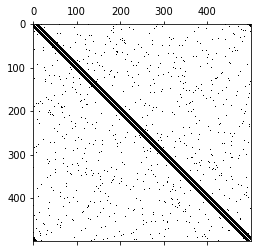

In [5]:
%%time
BN = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
plt.spy(BN.A)

In [6]:
%%time

TIME = 100
seed = int(size/2)
C = 10000
trials = 1

threshold = 0.1
memory = TIME
rest = 0

neurons_1 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_1)

old_settings = np.seterr(all = 'ignore')

CPU times: user 595 µs, sys: 180 µs, total: 775 µs
Wall time: 1.6 ms


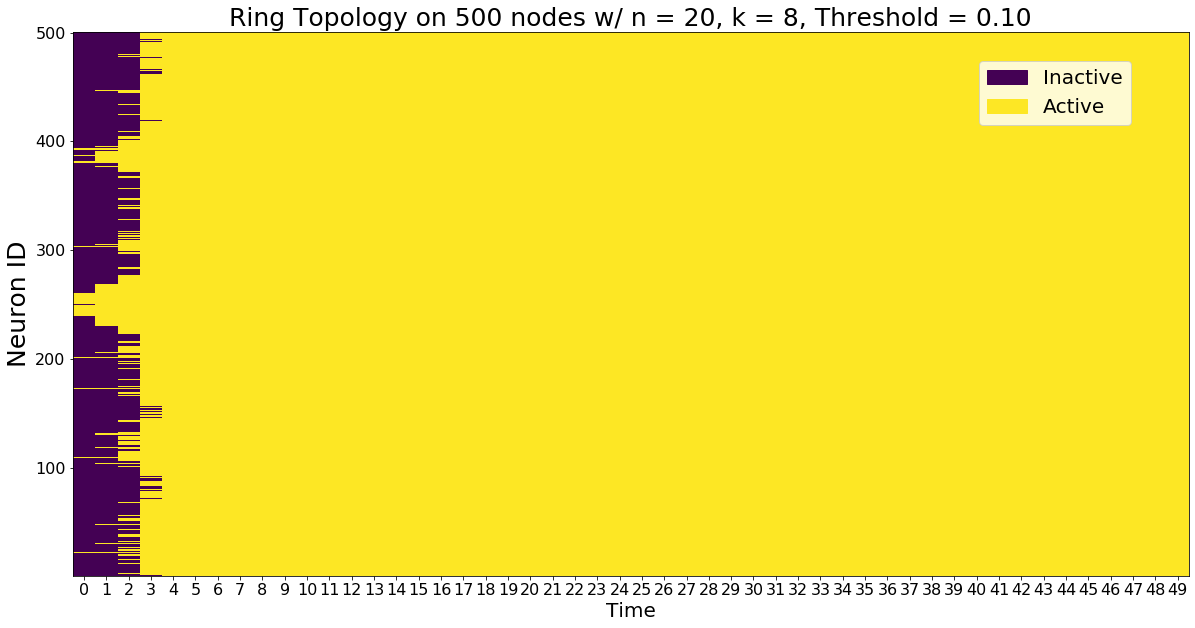

CPU times: user 607 ms, sys: 41.3 ms, total: 648 ms
Wall time: 678 ms


In [7]:
%%time
activation1, Q1 = BN.run_dynamic(seed, TIME, C)
fig,ax = plt.subplots(1,1, figsize = (20,10))
im = ax.imshow(BN.stack_histories(50), interpolation = 'nearest', aspect = 'auto', extent = [-0.5,50-0.5,0.5,size+0.5])
ax.set_xticks([i for i in range(50)])
ax.set_title(r'Ring Topology on 500 nodes w/ n = 20, k = 8, Threshold = %.2f'%(threshold), fontsize = 25)
ax.set_xlabel('Time', fontsize = 20)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 16)

values = np.unique(BN.stack_histories(50))
state = ['Inactive', 'Active']
# get the colors of the values, according to the 
# colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label = state[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.95), loc=0, borderaxespad=0.1, prop={'size': 20})

plt.show()

In [8]:
threshold = 0.2
memory = TIME
rest = 0

neurons_2 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_2)

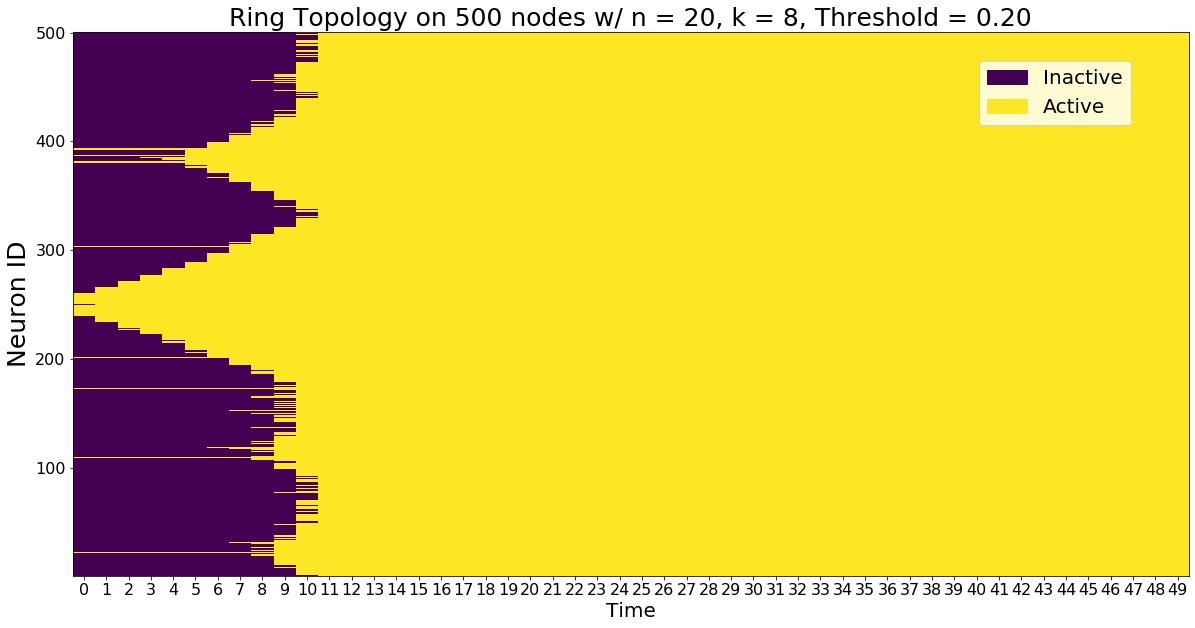

CPU times: user 604 ms, sys: 33.3 ms, total: 637 ms
Wall time: 665 ms


In [9]:
%%time
activation2, Q2 = BN.run_dynamic(seed, TIME, C)
fig,ax = plt.subplots(1,1, figsize = (20,10))
im = ax.imshow(BN.stack_histories(50), interpolation = 'nearest', aspect = 'auto', extent = [-0.5,50-0.5,0.5,size+0.5])
ax.set_xticks([i for i in range(50)])
ax.set_title(r'Ring Topology on 500 nodes w/ n = 20, k = 8, Threshold = %.2f'%(threshold), fontsize = 25)
ax.set_xlabel('Time', fontsize = 20)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 16)

values = np.unique(BN.stack_histories(50))
state = ['Inactive', 'Active']
# get the colors of the values, according to the 
# colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label = state[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.95), loc=0, borderaxespad=0.1, prop={'size': 20})

plt.show()

In [10]:
threshold = 0.3
memory = TIME
rest = 0

neurons_2 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_2)

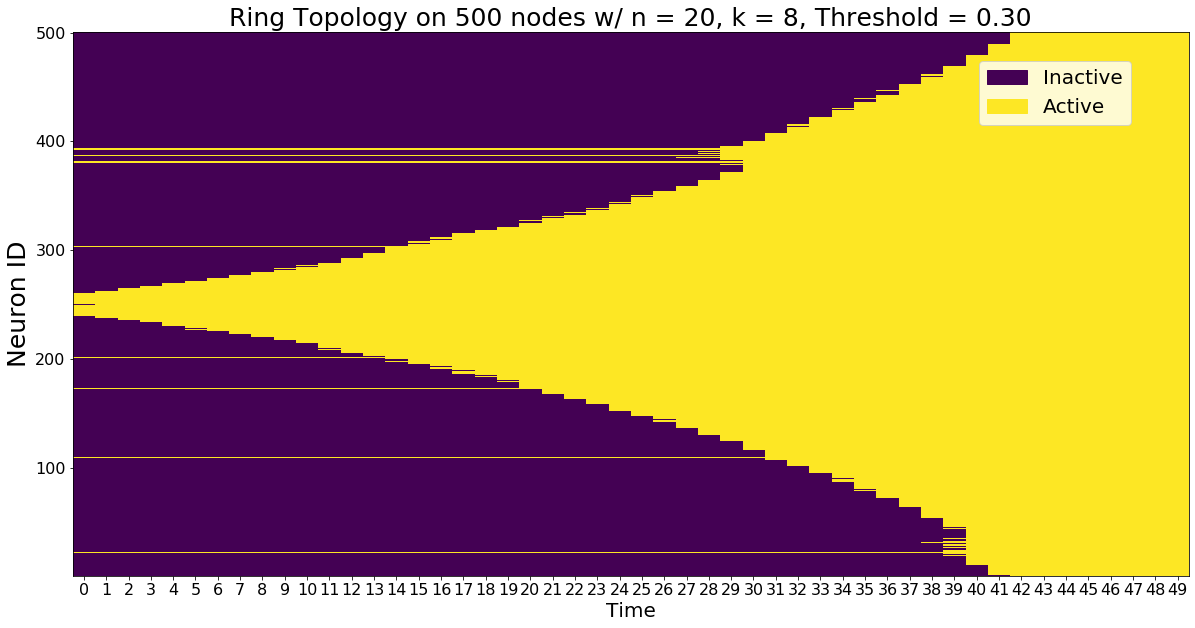

CPU times: user 719 ms, sys: 30.9 ms, total: 750 ms
Wall time: 766 ms


In [11]:
%%time
activation3, Q3 = BN.run_dynamic(seed, TIME, C)
fig,ax = plt.subplots(1,1, figsize = (20,10))
im = ax.imshow(BN.stack_histories(50), interpolation = 'nearest', aspect = 'auto', extent = [-0.5,50-0.5,0.5,size+0.5])
ax.set_xticks([i for i in range(50)])
ax.set_title(r'Ring Topology on 500 nodes w/ n = 20, k = 8, Threshold = %.2f'%(threshold), fontsize = 25)
ax.set_xlabel('Time', fontsize = 20)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 16)

values = np.unique(BN.stack_histories(50))
state = ['Inactive', 'Active']
# get the colors of the values, according to the 
# colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label = state[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.95), loc=0, borderaxespad=0.1, prop={'size': 20})

plt.show()

In [12]:
threshold = 0.4
memory = TIME
rest = 0

neurons_2 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_2)

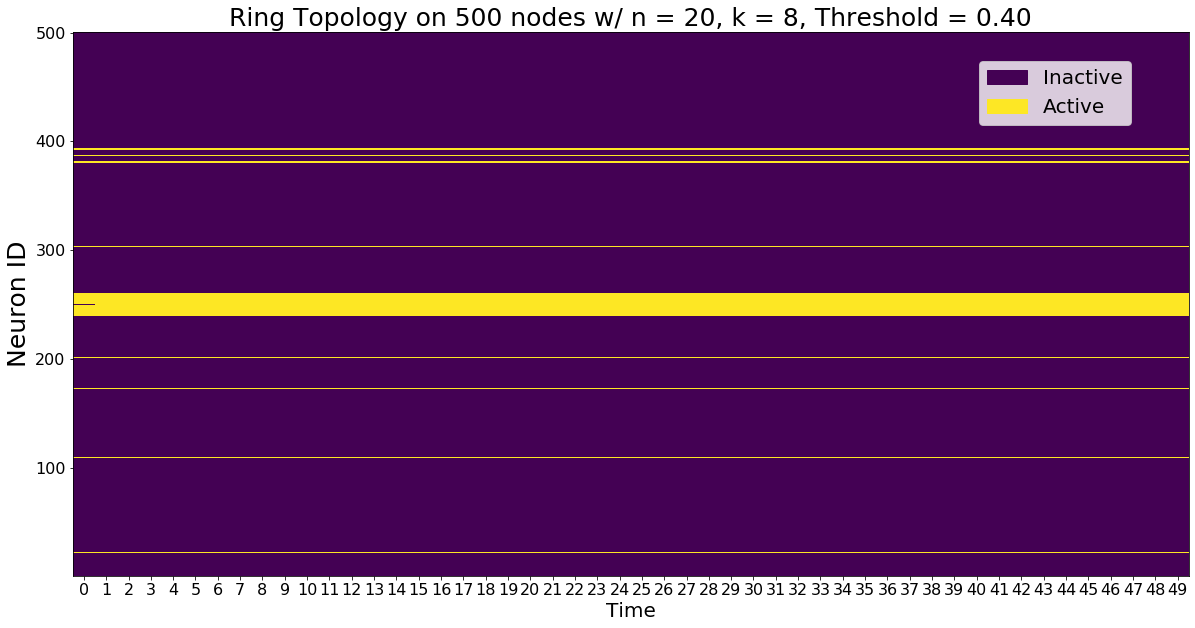

CPU times: user 675 ms, sys: 30.2 ms, total: 705 ms
Wall time: 733 ms


In [13]:
%%time
activation4, Q4 = BN.run_dynamic(seed, TIME, C)
fig,ax = plt.subplots(1,1, figsize = (20,10))
im = ax.imshow(BN.stack_histories(50), interpolation = 'nearest', aspect = 'auto', extent = [-0.5,50-0.5,0.5,size+0.5])
ax.set_xticks([i for i in range(50)])
ax.set_title(r'Ring Topology on 500 nodes w/ n = 20, k = 8, Threshold = %.2f'%(threshold), fontsize = 25)
ax.set_xlabel('Time', fontsize = 20)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 16)

values = np.unique(BN.stack_histories(50))
state = ['Inactive', 'Active']
# get the colors of the values, according to the 
# colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label = state[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.95), loc=0, borderaxespad=0.1, prop={'size': 20})

plt.show()

In [14]:
threshold = 0.5
memory = TIME
rest = 0

neurons_2 = [neuron(i, memory = memory, rest = rest, threshold = threshold) for i in range(size)]

BN.get_neurons(neurons_2)

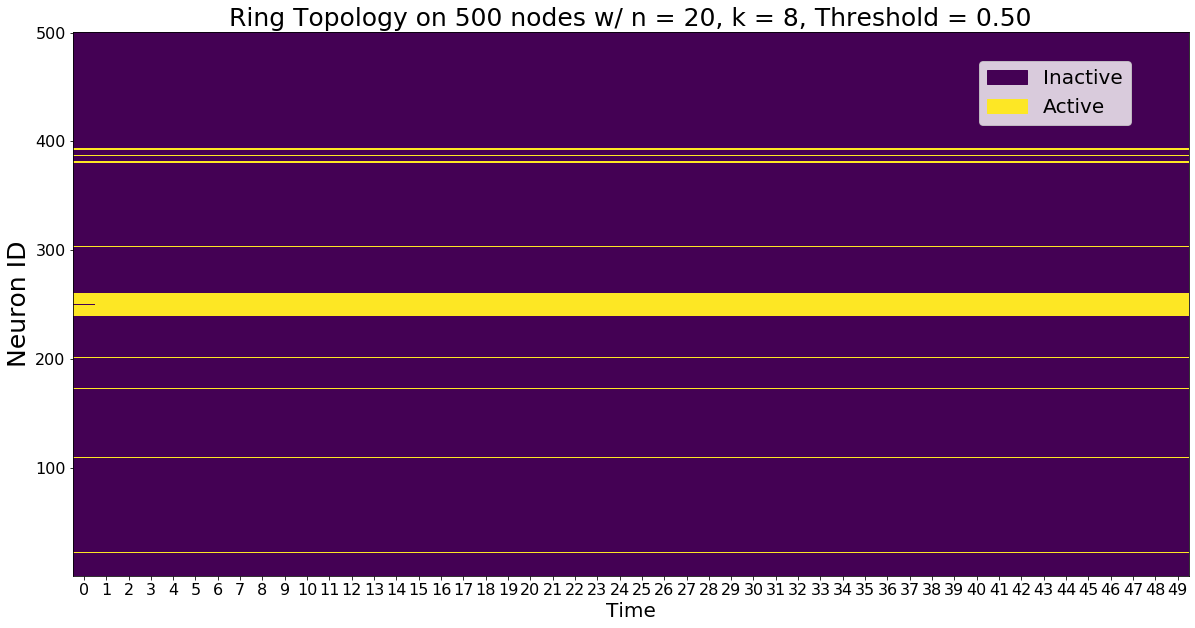

CPU times: user 701 ms, sys: 33.1 ms, total: 734 ms
Wall time: 765 ms


In [15]:
%%time
activation5, Q5 = BN.run_dynamic(seed, TIME, C)
fig,ax = plt.subplots(1,1, figsize = (20,10))
im = ax.imshow(BN.stack_histories(50), interpolation = 'nearest', aspect = 'auto', extent = [-0.5,50-0.5,0.5,size+0.5])
ax.set_xticks([i for i in range(50)])
ax.set_title(r'Ring Topology on 500 nodes w/ n = 20, k = 8, Threshold = %.2f'%(threshold), fontsize = 25)
ax.set_xlabel('Time', fontsize = 20)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.tick_params(axis = 'both', labelsize = 16)

values = np.unique(BN.stack_histories(50))
state = ['Inactive', 'Active']
# get the colors of the values, according to the 
# colormap used by imshow
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label = state[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.95), loc=0, borderaxespad=0.1, prop={'size': 20})

plt.show()

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff4478fe550>)

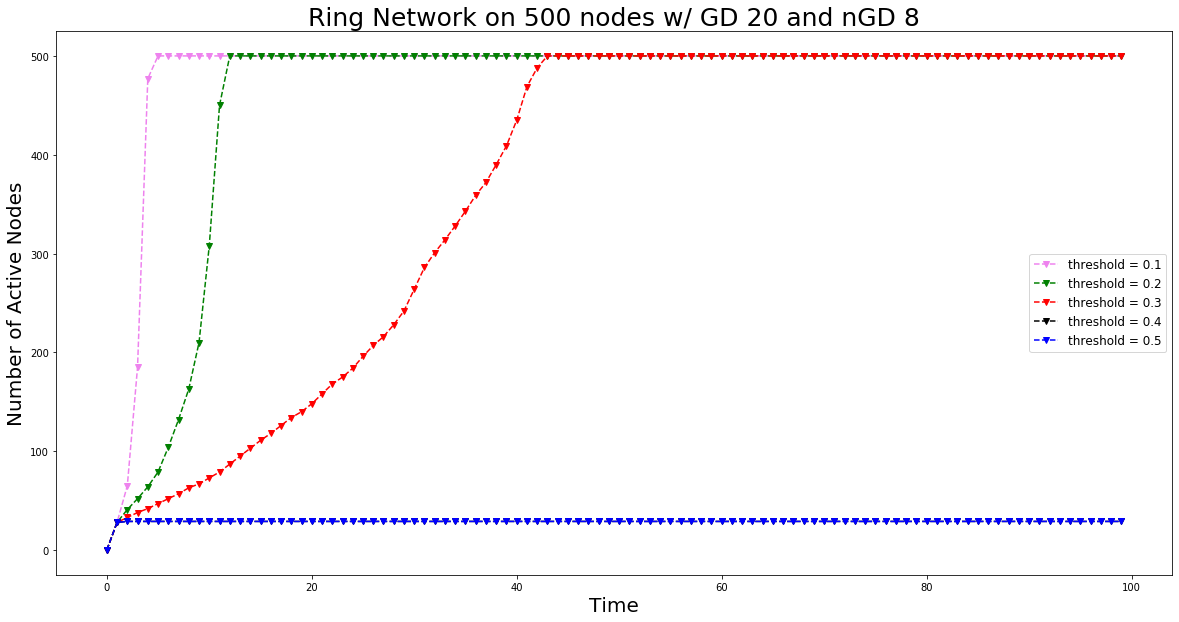

In [16]:
Q = [Q1,Q2,Q3,Q4,Q5]
labels = ['threshold = 0.1', 'threshold = 0.2', 'threshold = 0.3', 'threshold = 0.4', 'threshold = 0.5' ]
BN.display_comm_sizes_individual(Q,labels)

## Full Experiment

In [4]:
def spy_distance_matrix(distance_matrix, N, nGD):
    fig,ax = plt.subplots(1,1, figsize = (10,10))
    pos = ax.imshow(distance_matrix, origin = 'lower', interpolation = 'nearest', 
                    aspect = 'auto', cmap = 'viridis', extent = [-0.5, N-0.5, -0.5, N-0.5])
    ax.set_title('Ring Manifold w/ size 500, GD = 20, nGD = %d, Threshold = 0.1'%nGD, fontsize = 30)
    ax.set_ylabel('Excitation starting from node i', fontsize = 25)
    ax.set_xlabel('First time node j gets activated', fontsize = 25)
    ax.set_xticks([i*20 for i in range(int(N/20)+1)])
    ax.set_yticks([i*20 for i in range(int(N/20)+1)])

    #cbar = fig.colorbar(pos, ax = ax)
        
    return(fig,ax)

In [5]:
size = 500
GD = 20
nGD = 0
topology = 'Ring'

TIME = 100
trials = 1
C = 1000

memory = TIME
rest = 0

CPU times: user 35.4 ms, sys: 8.85 ms, total: 44.2 ms
Wall time: 58.4 ms


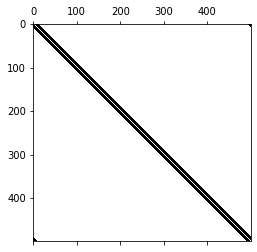

In [6]:
%%time
GBN1 = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
Adjacency = GBN1.A
plt.spy(Adjacency)

In [7]:
%%time
threshold1 = 0.1
neurons1 = [neuron(i, memory = memory, rest = rest, threshold = threshold1) for i in range(size)]

GBN1.get_neurons(neurons1)

CPU times: user 516 µs, sys: 66 µs, total: 582 µs
Wall time: 589 µs


CPU times: user 47.4 s, sys: 283 ms, total: 47.6 s
Wall time: 50.8 s


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9549e8b410>)

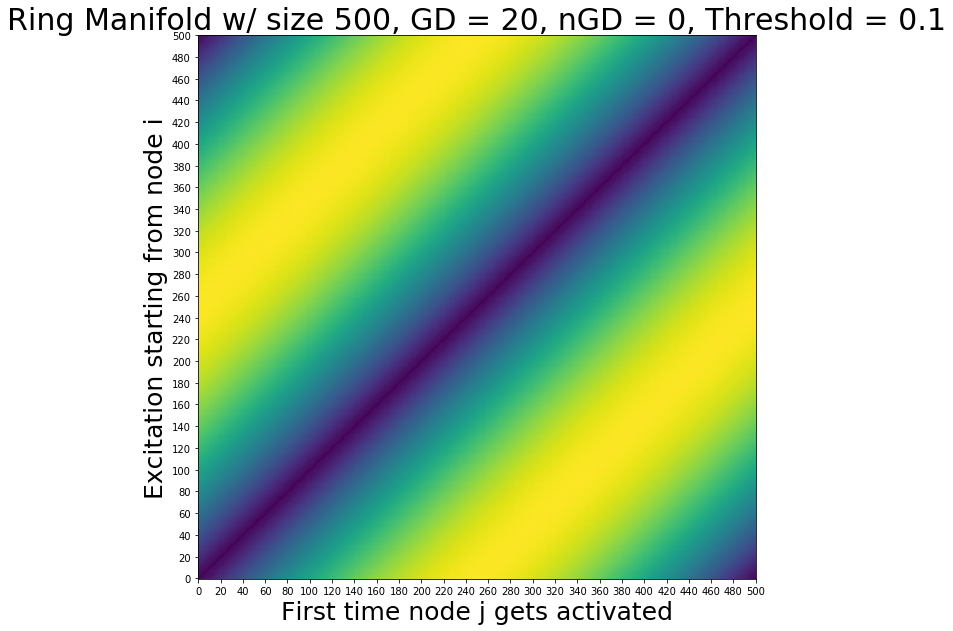

In [8]:
%%time
FAT1, QS1 = GBN1.make_distance_matrix(TIME, C, trials)
spy_distance_matrix(FAT1,size,nGD)

Deprecated parameter. It has been replaced by max_intervals
CPU times: user 28.6 s, sys: 1.73 s, total: 30.3 s
Wall time: 31.5 s


(0.8317276239395142, 0.0)

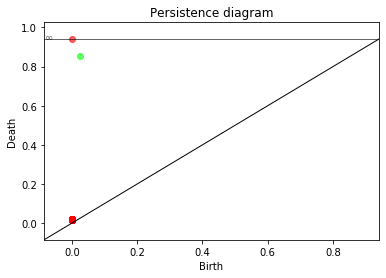

In [9]:
%%time
GBN1.compute_persistence(FAT1, spy = True)

In [10]:
size = 500
GD = 20
nGD = 4
topology = 'Ring'

TIME = 100
trials = 1
C = 1000

memory = TIME
rest = 0

CPU times: user 994 ms, sys: 10.9 ms, total: 1 s
Wall time: 1.06 s


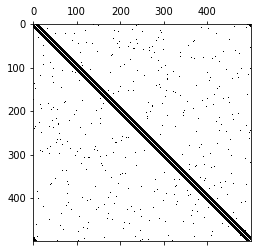

In [11]:
%%time
GBN2 = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
Adjacency = GBN2.A
plt.spy(Adjacency)

In [12]:
%%time
threshold2 = 0.1
neurons2 = [neuron(i, memory = memory, rest = rest, threshold = threshold2) for i in range(size)]

GBN2.get_neurons(neurons2)

CPU times: user 396 µs, sys: 1 µs, total: 397 µs
Wall time: 402 µs


CPU times: user 17.5 s, sys: 134 ms, total: 17.6 s
Wall time: 22.3 s


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f94f2d01510>)

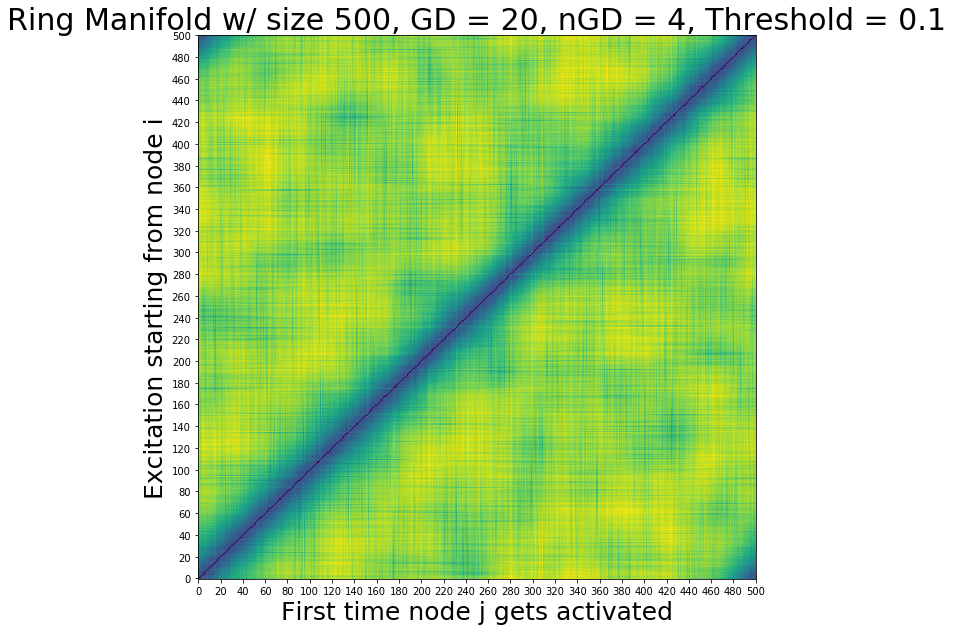

In [13]:
%%time
FAT2, QS2 = GBN2.make_distance_matrix(TIME, C, trials)
spy_distance_matrix(FAT2,size,nGD)

Deprecated parameter. It has been replaced by max_intervals
CPU times: user 31.1 s, sys: 1.06 s, total: 32.1 s
Wall time: 34.4 s


(0.2672034502029419, 0.44079020619392395)

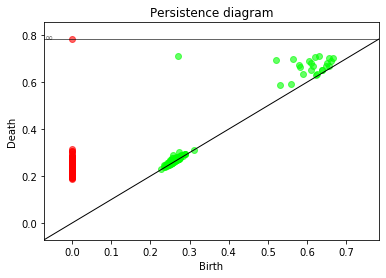

In [14]:
%%time
GBN2.compute_persistence(FAT2, spy = True)

In [22]:
size = 500
GD = 20
nGD = 15
topology = 'Ring'

TIME = 100
trials = 1
C = 1000

memory = TIME
rest = 0

CPU times: user 13.7 s, sys: 121 ms, total: 13.8 s
Wall time: 15.5 s


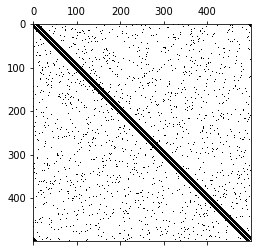

In [23]:
%%time
GBN3 = Geometric_Brain_Network(size, geometric_degree = GD, nongeometric_degree = nGD, manifold = topology)
Adjacency = GBN3.A
plt.spy(Adjacency)

In [24]:
%%time
threshold3 = 0.1
neurons3 = [neuron(i, memory = memory, rest = rest, threshold = threshold3) for i in range(size)]

GBN3.get_neurons(neurons3)

CPU times: user 950 µs, sys: 965 µs, total: 1.91 ms
Wall time: 1.88 ms


CPU times: user 10.4 s, sys: 106 ms, total: 10.5 s
Wall time: 11.6 s


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f94f43384d0>)

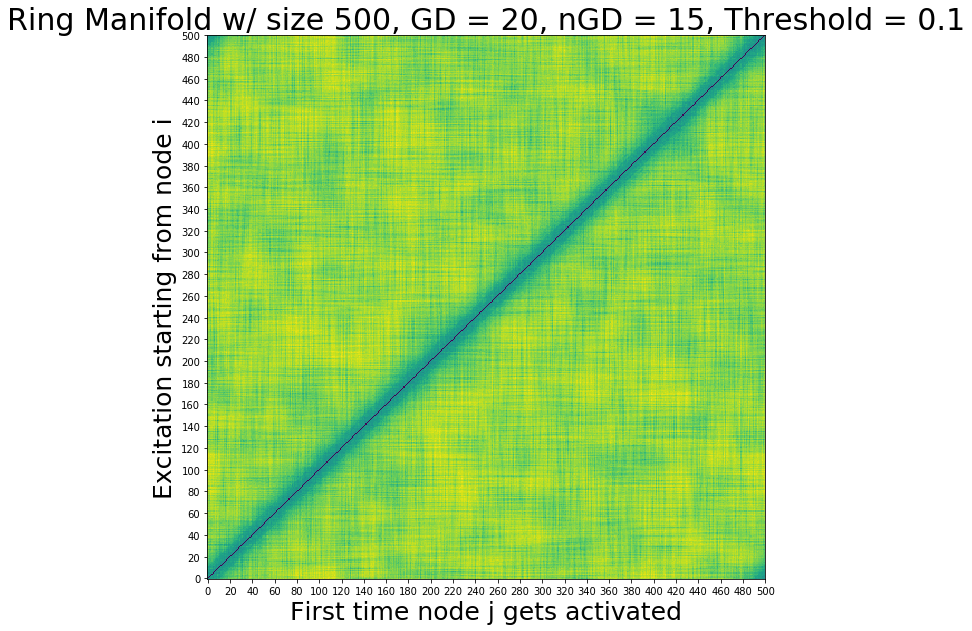

In [25]:
%%time
FAT3, QS3 = GBN3.make_distance_matrix(TIME, C, trials)
spy_distance_matrix(FAT3,size,nGD)

Deprecated parameter. It has been replaced by max_intervals
CPU times: user 33.2 s, sys: 1.78 s, total: 35 s
Wall time: 39.7 s


(0.06489315629005432, 0.18294663727283478)

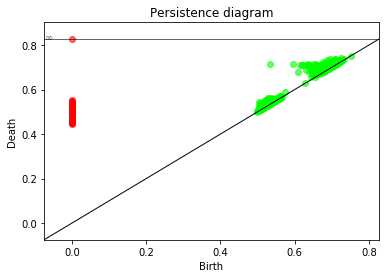

In [26]:
%%time
GBN3.compute_persistence(FAT3, spy = True)

Text(0.5, 1.0, 'Ring Network on 500 nodes w/ GD = 20, Threhsold = 0.1')

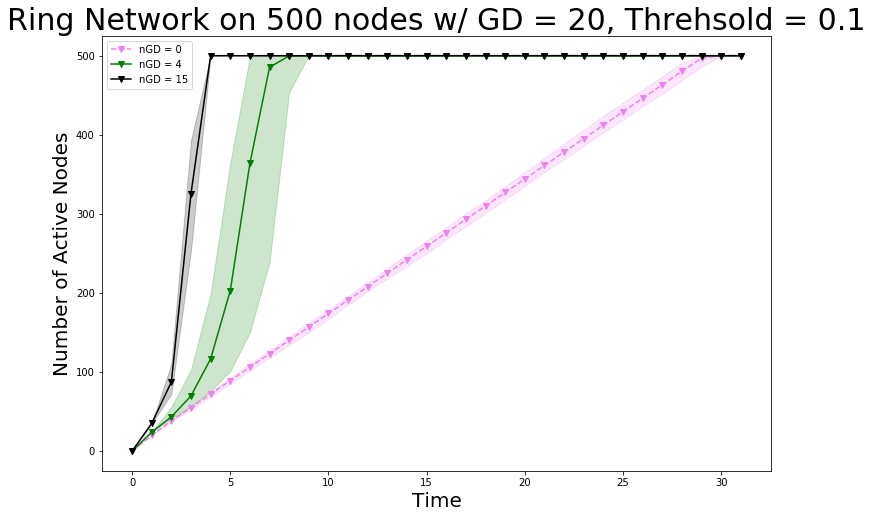

In [33]:
Q = [QS1,QS2,QS3]
labels = [0,4,15]
fig,ax = GBN2.display_comm_sizes(Q,labels, TIME, C, trials, memory, rest)
ax.set_title('Ring Network on 500 nodes w/ GD = 20, Threhsold = 0.1', fontsize = 30 )